# Model Experiments
Objective: Build XGBoost multi-output model for 24-hour solar power forecasting using only historical data

## 1. Setup and imports

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv

# Explicit .env loading for Jupyter (Docker works, Jupyter needs this)
env_file = Path("../.env")  # .env is in project root
if env_file.exists():
    load_dotenv(env_file)
    print(".env file loaded successfully")
    print(f"DB_PASSWORD length: {len(os.getenv('DB_PASSWORD', ''))} chars")
else:
    print(".env file not found at ../.env")
    print("Current working directory:", os.getcwd())

.env file loaded successfully
DB_PASSWORD length: 20 chars


In [2]:
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID", "test")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY", "test")
os.environ["AWS_DEFAULT_REGION"] = os.getenv("AWS_DEFAULT_REGION", "us-east-1")
os.environ["MLFLOW_S3_ENDPOINT_URL"] = os.getenv("AWS_ENDPOINT_URL", "http://localhost:4566")

print("MLflow S3 environment configured:")
print(f"   S3 Endpoint: {os.environ['MLFLOW_S3_ENDPOINT_URL']}")

MLflow S3 environment configured:
   S3 Endpoint: http://localhost:4566


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os
import warnings
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Any

# Suppress warnings
warnings.filterwarnings("ignore")

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
# Import custom modules
from src.data.preprocessor import SolarForecastingPreprocessor
from src.utils.mlflow_utils import (
    setup_mlflow_tracking, 
    start_mlflow_run, 
    log_model_metrics, 
    log_model_params,
    get_or_create_experiment
)
from src.config.settings import get_settings

# Import ML libraries
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import mlflow
import mlflow.sklearn

In [5]:
# Initialize MLflow
setup_mlflow_tracking()
print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")

# Create experiment
experiment_name = "solar-forecasting-xgboost-timeseries"
experiment_id = get_or_create_experiment(experiment_name)
print(f"Experiment: {experiment_name} (ID: {experiment_id})")

INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:Using existing active experiment: solar-forecasting-xgboost-timeseries


MLflow tracking URI: http://localhost:5000
Experiment: solar-forecasting-xgboost-timeseries (ID: 1)


## 2. Data Loading & Preprocessing

In [6]:
# Load preprocessed data
print("Loading preprocessed forecasting data...")

preprocessor = SolarForecastingPreprocessor(
    forecast_horizon=24,
    lag_days=[1, 2, 3, 7, 30],
    rolling_windows=[7, 30],
    scaling_method='standard'
)

# Load and create forecasting dataset
X, y, metadata = preprocessor.fit_transform(
    "../data/raw/Plant_1_Generation_Data.csv",
    "../data/raw/Plant_1_Weather_Sensor_Data.csv"
)

print(f"Data loaded: X {X.shape}, y {y.shape}")
print(f"Features: {len(preprocessor.get_feature_names())}")
print(f"Forecast horizon: {preprocessor.forecast_horizon}h")

INFO:src.data.preprocessor:Initialized SolarForecastingPreprocessor: horizon=24h, lags=[1, 2, 3, 7, 30] days, rolling_windows=[7, 30] days, scaling=standard
INFO:src.data.preprocessor:Starting complete forecasting preprocessing pipeline...
INFO:src.data.preprocessor:Loading solar generation data...
INFO:src.data.preprocessor:Resampling to hourly frequency...


Loading preprocessed forecasting data...


INFO:src.data.preprocessor:Removed 20 NaN rows after resampling
INFO:src.data.preprocessor:Data loaded successfully: 796 records from 2020-05-15 00:00:00 to 2020-06-17 23:00:00
INFO:src.data.preprocessor:Validating forecasting setup for data leakage...
INFO:src.data.preprocessor:✅ Forecasting setup validation PASSED
INFO:src.data.preprocessor:Creating forecasting dataset...
INFO:src.data.preprocessor:Creating historical lag features...
INFO:src.data.preprocessor:Created 5 lag features and 2 rolling features
INFO:src.data.preprocessor:Creating temporal features for future dates...
INFO:src.data.preprocessor:Created 16 temporal features
INFO:src.data.preprocessor:Forecasting dataset created: X shape (52, 32), y shape (52, 24)
INFO:src.data.preprocessor:Removed 744 rows with missing values
INFO:src.data.preprocessor:Preprocessing complete! X shape: (52, 32), y shape: (52, 24)
INFO:src.data.preprocessor:Features: 31, Targets: 24


Data loaded: X (52, 32), y (52, 24)
Features: 31
Forecast horizon: 24h


## 3. Time Series Validation Setup

In [7]:
def create_time_series_split(X: pd.DataFrame, y: pd.DataFrame, n_splits: int = 3) -> Tuple[List, List]:
    """
    Create time series splits respecting temporal order.
    
    Args:
        X: Features dataframe with DATE_TIME column
        y: Targets dataframe
        n_splits: Number of splits for cross-validation
        
    Returns:
        Tuple of train and test indices lists
    """
    # Use TimeSeriesSplit for proper temporal validation
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=7)  # 7 samples test size
    
    # Get indices without DATE_TIME column
    X_features = X.drop('DATE_TIME', axis=1)
    
    train_indices = []
    test_indices = []
    
    for train_idx, test_idx in tscv.split(X_features):
        train_indices.append(train_idx)
        test_indices.append(test_idx)
        
    print(f"Created {n_splits} time series splits")
    for i, (train_idx, test_idx) in enumerate(zip(train_indices, test_indices)):
        train_dates = X.iloc[train_idx]['DATE_TIME']
        test_dates = X.iloc[test_idx]['DATE_TIME']
        print(f"   Split {i+1}: Train {train_dates.min()} to {train_dates.max()}")
        print(f"             Test  {test_dates.min()} to {test_dates.max()}")
    
    return train_indices, test_indices

# Create time series splits
train_splits, test_splits = create_time_series_split(X, y, n_splits=3)

Created 3 time series splits
   Split 1: Train 2020-06-14 20:00:00 to 2020-06-16 02:00:00
             Test  2020-06-16 03:00:00 to 2020-06-16 09:00:00
   Split 2: Train 2020-06-14 20:00:00 to 2020-06-16 09:00:00
             Test  2020-06-16 10:00:00 to 2020-06-16 16:00:00
   Split 3: Train 2020-06-14 20:00:00 to 2020-06-16 16:00:00
             Test  2020-06-16 17:00:00 to 2020-06-16 23:00:00


In [8]:
def calculate_forecast_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """
    Calculate comprehensive forecasting metrics.
    
    Args:
        y_true: True values (samples, horizon)
        y_pred: Predicted values (samples, horizon)
        
    Returns:
        Dictionary of metrics
    """
    metrics = {}
    
    # Overall metrics
    metrics['rmse_overall'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics['mae_overall'] = mean_absolute_error(y_true, y_pred)
    metrics['r2_overall'] = r2_score(y_true.flatten(), y_pred.flatten())
    
    # Per-horizon metrics (important for multi-step forecasting)
    horizon_rmse = []
    horizon_mae = []
    
    for h in range(y_true.shape[1]):
        h_rmse = np.sqrt(mean_squared_error(y_true[:, h], y_pred[:, h]))
        h_mae = mean_absolute_error(y_true[:, h], y_pred[:, h])
        horizon_rmse.append(h_rmse)
        horizon_mae.append(h_mae)
        
        # Log key horizons (1h, 6h, 12h, 24h)
        if h + 1 in [1, 6, 12, 24]:
            metrics[f'rmse_{h+1}h'] = h_rmse
            metrics[f'mae_{h+1}h'] = h_mae
    
    metrics['rmse_horizon_mean'] = np.mean(horizon_rmse)
    metrics['rmse_horizon_std'] = np.std(horizon_rmse)
    metrics['mae_horizon_mean'] = np.mean(horizon_mae)
    metrics['mae_horizon_std'] = np.std(horizon_mae)
    
    return metrics

## 4. XGBoost Multi-Output Model

In [9]:
def create_xgboost_multi_output_model(
    n_estimators: int = 100,
    max_depth: int = 6,
    learning_rate: float = 0.1,
    subsample: float = 0.8,
    colsample_bytree: float = 0.8,
    random_state: int = 42
) -> MultiOutputRegressor:
    """
    Create XGBoost multi-output regressor for 24-hour forecasting.
    
    Args:
        n_estimators: Number of boosting rounds
        max_depth: Maximum tree depth
        learning_rate: Learning rate
        subsample: Subsample ratio
        colsample_bytree: Column subsample ratio
        random_state: Random state for reproducibility
        
    Returns:
        Configured MultiOutputRegressor with XGBoost
    """
    # Base XGBoost regressor
    xgb_base = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=random_state,
        n_jobs=-1,  # Use all available cores
        verbosity=0  # Suppress XGBoost output
    )
    
    # Multi-output wrapper
    model = MultiOutputRegressor(xgb_base, n_jobs=-1)
    
    return model

# Test model creation
print("Testing XGBoost multi-output model creation...")
test_model = create_xgboost_multi_output_model()
print(f"Model created: {type(test_model).__name__}")
print(f"   Base estimator: {type(test_model.estimator).__name__}")
print(f"   Target outputs: {preprocessor.forecast_horizon}")

Testing XGBoost multi-output model creation...
Model created: MultiOutputRegressor
   Base estimator: XGBRegressor
   Target outputs: 24


## 5. Hyperparameter Tuning & Training

In [10]:
def run_xgboost_experiment(
    X_train: pd.DataFrame, 
    y_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_test: pd.DataFrame,
    params: Dict[str, Any],
    experiment_name: str
) -> Tuple[MultiOutputRegressor, Dict[str, float]]:
    """
    Run single XGBoost experiment with MLflow tracking.
    
    Args:
        X_train, y_train: Training data
        X_test, y_test: Testing data  
        params: Model parameters
        experiment_name: Name for MLflow run
        
    Returns:
        Tuple of trained model and metrics
    """
    with start_mlflow_run(experiment_name=experiment_name, run_name=f"xgb_{datetime.now().strftime('%H%M%S')}"):
        
        # Log parameters
        log_model_params(params)
        log_model_params({
            'train_samples': len(X_train),
            'test_samples': len(X_test),
            'features': X_train.shape[1] - 1,  # Exclude DATE_TIME
            'forecast_horizon': y_train.shape[1]
        })
        
        # Create and train model
        model = create_xgboost_multi_output_model(**params)
        
        # Remove DATE_TIME for training
        X_train_features = X_train.drop('DATE_TIME', axis=1)
        X_test_features = X_test.drop('DATE_TIME', axis=1)
        
        print(f"Training XGBoost model...")
        start_time = datetime.now()
        model.fit(X_train_features, y_train)
        training_time = (datetime.now() - start_time).total_seconds()
        
        # Make predictions
        y_pred_train = model.predict(X_train_features)
        y_pred_test = model.predict(X_test_features)
        
        # Calculate metrics
        train_metrics = calculate_forecast_metrics(y_train.values, y_pred_train)
        test_metrics = calculate_forecast_metrics(y_test.values, y_pred_test)
        
        # Log metrics with prefix
        train_metrics_prefixed = {f'train_{k}': v for k, v in train_metrics.items()}
        test_metrics_prefixed = {f'test_{k}': v for k, v in test_metrics.items()}
        
        log_model_metrics(train_metrics_prefixed)
        log_model_metrics(test_metrics_prefixed)
        log_model_metrics({'training_time_seconds': training_time})
        
        # Log model
        mlflow.sklearn.log_model(model, "xgboost_multi_output_model")
        
        print(f"✅ Training completed in {training_time:.1f}s")
        print(f"   Test RMSE: {test_metrics['rmse_overall']:.2f}")
        print(f"   Test MAE:  {test_metrics['mae_overall']:.2f}")
        print(f"   Test R²:   {test_metrics['r2_overall']:.3f}")
        
        return model, test_metrics

# Define parameter grid for tuning
param_grid = [
    {
        'n_estimators': 50,
        'max_depth': 4,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    },
    {
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.05,
        'subsample': 0.9,
        'colsample_bytree': 0.9
    },
    {
        'n_estimators': 150,
        'max_depth': 8,
        'learning_rate': 0.02,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }
]

print(f"Running hyperparameter tuning with {len(param_grid)} configurations...")

# Run experiments on time series splits
best_models = []
best_scores = []

for split_idx, (train_idx, test_idx) in enumerate(zip(train_splits, test_splits)):
    print(f"\n === TIME SERIES SPLIT {split_idx + 1} ===")
    
    # Split data
    X_train = X.iloc[train_idx].reset_index(drop=True)
    y_train = y.iloc[train_idx].reset_index(drop=True)
    X_test = X.iloc[test_idx].reset_index(drop=True)
    y_test = y.iloc[test_idx].reset_index(drop=True)
    
    split_best_model = None
    split_best_score = float('inf')
    
    # Test each parameter configuration
    for param_idx, params in enumerate(param_grid):
        print(f"\n Testing params {param_idx + 1}/{len(param_grid)}: {params}")
        
        try:
            model, metrics = run_xgboost_experiment(
                X_train, y_train, X_test, y_test, 
                params, experiment_name
            )
            
            # Track best model for this split
            test_rmse = metrics['rmse_overall']
            if test_rmse < split_best_score:
                split_best_score = test_rmse
                split_best_model = model
                
        except Exception as e:
            print(f"❌ Experiment failed: {e}")
            continue
    
    best_models.append(split_best_model)
    best_scores.append(split_best_score)
    print(f"✅ Split {split_idx + 1} best RMSE: {split_best_score:.2f}")

print(f"\nHYPERPARAMETER TUNING COMPLETE")
print(f"   Best scores per split: {[f'{score:.2f}' for score in best_scores]}")
print(f"   Average best RMSE: {np.mean(best_scores):.2f} ± {np.std(best_scores):.2f}")

INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:Using existing active experiment: solar-forecasting-xgboost-timeseries


Running hyperparameter tuning with 3 configurations...

 === TIME SERIES SPLIT 1 ===

 Testing params 1/3: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}


INFO:src.utils.mlflow_utils:Started MLflow run: 597cd1a4dd2a4d9b90ab26bcb47d2b9c
INFO:src.utils.mlflow_utils:Logged 5 parameters to MLflow
INFO:src.utils.mlflow_utils:Logged 4 parameters to MLflow


Training XGBoost model...


INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 1 metrics to MLflow
2025/07/29 09:20:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/29 09:20:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:Using existing active experiment: solar-forecasting-xgboost-timeseries
INFO:src.utils.mlflow_utils:Started MLflow 

✅ Training completed in 4.1s
   Test RMSE: 154.20
   Test MAE:  102.85
   Test R²:   0.761
🏃 View run xgb_091959 at: http://localhost:5000/#/experiments/1/runs/597cd1a4dd2a4d9b90ab26bcb47d2b9c
🧪 View experiment at: http://localhost:5000/#/experiments/1

 Testing params 2/3: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.9}
Training XGBoost model...


INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 1 metrics to MLflow
2025/07/29 09:20:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/29 09:20:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:Using existing active experiment: solar-forecasting-xgboost-timeseries
INFO:src.utils.mlflow_utils:Started MLflow run: 0c6d474db0e94249a0d1f954662babce
INFO:src.utils.mlflow_utils:Logg

✅ Training completed in 0.5s
   Test RMSE: 173.47
   Test MAE:  107.57
   Test R²:   0.698
🏃 View run xgb_092009 at: http://localhost:5000/#/experiments/1/runs/a22c9630aa78463ab6d5403fce0f50ab
🧪 View experiment at: http://localhost:5000/#/experiments/1

 Testing params 3/3: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.02, 'subsample': 0.8, 'colsample_bytree': 0.8}
Training XGBoost model...


INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 1 metrics to MLflow
2025/07/29 09:20:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/29 09:20:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:Using existing active experiment: solar-forecasting-xgboost-timeseries
INFO:src.utils.mlflow_utils:Started MLflow run: e2548bc07ba94439affb52c5298f5e12
INFO:src.utils.mlflow_utils:Logg

✅ Training completed in 0.6s
   Test RMSE: 159.75
   Test MAE:  106.62
   Test R²:   0.743
🏃 View run xgb_092013 at: http://localhost:5000/#/experiments/1/runs/0c6d474db0e94249a0d1f954662babce
🧪 View experiment at: http://localhost:5000/#/experiments/1
✅ Split 1 best RMSE: 154.20

 === TIME SERIES SPLIT 2 ===

 Testing params 1/3: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}
Training XGBoost model...


INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 1 metrics to MLflow
2025/07/29 09:20:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/29 09:20:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:Using existing active experiment: solar-forecasting-xgboost-timeseries
INFO:src.utils.mlflow_utils:Started MLflow run: 53e4c212bd4a424aab39378bb170b667
INFO:src.utils.mlflow_utils:Logg

✅ Training completed in 0.3s
   Test RMSE: 177.98
   Test MAE:  109.91
   Test R²:   0.690
🏃 View run xgb_092018 at: http://localhost:5000/#/experiments/1/runs/e2548bc07ba94439affb52c5298f5e12
🧪 View experiment at: http://localhost:5000/#/experiments/1

 Testing params 2/3: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.9}
Training XGBoost model...


INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 1 metrics to MLflow
2025/07/29 09:20:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/29 09:20:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:Using existing active experiment: solar-forecasting-xgboost-timeseries
INFO:src.utils.mlflow_utils:Started MLflow run: 12a54f83195944aabb6ea37bb1293528
INFO:src.utils.mlflow_utils:Logg

✅ Training completed in 0.5s
   Test RMSE: 181.74
   Test MAE:  109.61
   Test R²:   0.677
🏃 View run xgb_092021 at: http://localhost:5000/#/experiments/1/runs/53e4c212bd4a424aab39378bb170b667
🧪 View experiment at: http://localhost:5000/#/experiments/1

 Testing params 3/3: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.02, 'subsample': 0.8, 'colsample_bytree': 0.8}
Training XGBoost model...


INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 1 metrics to MLflow
2025/07/29 09:20:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/29 09:20:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:Using existing active experiment: solar-forecasting-xgboost-timeseries
INFO:src.utils.mlflow_utils:Started MLflow run: 5e5bb7deadfa45ec9b3466d591855139
INFO:src.utils.mlflow_utils:Logg

✅ Training completed in 0.8s
   Test RMSE: 176.96
   Test MAE:  113.48
   Test R²:   0.693
🏃 View run xgb_092025 at: http://localhost:5000/#/experiments/1/runs/12a54f83195944aabb6ea37bb1293528
🧪 View experiment at: http://localhost:5000/#/experiments/1
✅ Split 2 best RMSE: 176.96

 === TIME SERIES SPLIT 3 ===

 Testing params 1/3: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}
Training XGBoost model...


INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 1 metrics to MLflow
2025/07/29 09:20:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/29 09:20:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:Using existing active experiment: solar-forecasting-xgboost-timeseries
INFO:src.utils.mlflow_utils:Started MLflow run: 2045586b72ab4c428bbd9b6c2a840738
INFO:src.utils.mlflow_utils:Logg

✅ Training completed in 0.3s
   Test RMSE: 191.37
   Test MAE:  117.59
   Test R²:   0.671
🏃 View run xgb_092030 at: http://localhost:5000/#/experiments/1/runs/5e5bb7deadfa45ec9b3466d591855139
🧪 View experiment at: http://localhost:5000/#/experiments/1

 Testing params 2/3: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.9}


INFO:src.utils.mlflow_utils:Logged 4 parameters to MLflow


Training XGBoost model...


INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 1 metrics to MLflow
2025/07/29 09:20:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/29 09:20:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:Using existing active experiment: solar-forecasting-xgboost-timeseries
INFO:src.utils.mlflow_utils:Started MLflow run: 77155cddb5cb44a694e928a80f831808
INFO:src.utils.mlflow_utils:Logg

✅ Training completed in 0.6s
   Test RMSE: 198.74
   Test MAE:  121.27
   Test R²:   0.645
🏃 View run xgb_092034 at: http://localhost:5000/#/experiments/1/runs/2045586b72ab4c428bbd9b6c2a840738
🧪 View experiment at: http://localhost:5000/#/experiments/1

 Testing params 3/3: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.02, 'subsample': 0.8, 'colsample_bytree': 0.8}
Training XGBoost model...


INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 1 metrics to MLflow
2025/07/29 09:20:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/29 09:20:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Training completed in 0.7s
   Test RMSE: 182.97
   Test MAE:  118.42
   Test R²:   0.699
🏃 View run xgb_092038 at: http://localhost:5000/#/experiments/1/runs/77155cddb5cb44a694e928a80f831808
🧪 View experiment at: http://localhost:5000/#/experiments/1
✅ Split 3 best RMSE: 182.97

HYPERPARAMETER TUNING COMPLETE
   Best scores per split: ['154.20', '176.96', '182.97']
   Average best RMSE: 171.38 ± 12.39


## 6. Final Model Training & Evaluation

In [11]:
# Train final model on full dataset with best parameters
print("Training final model on full dataset...")

# Use the best parameters (you can adjust based on results above)
final_params = {
    'n_estimators': 50,
    'max_depth': 4,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Create train/test split (last 20% for testing)
split_point = int(0.8 * len(X))
X_train_final = X.iloc[:split_point].reset_index(drop=True)
y_train_final = y.iloc[:split_point].reset_index(drop=True)
X_test_final = X.iloc[split_point:].reset_index(drop=True)
y_test_final = y.iloc[split_point:].reset_index(drop=True)

print(f"   Final train set: {X_train_final.shape}")
print(f"   Final test set:  {X_test_final.shape}")

# Train final model
final_model, final_metrics = run_xgboost_experiment(
    X_train_final, y_train_final, 
    X_test_final, y_test_final,
    final_params, 
    experiment_name="final_xgboost_model"
)

INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:MLflow tracking URI set to: http://localhost:5000
INFO:src.utils.mlflow_utils:MLflow server will handle S3 artifacts automatically
INFO:src.utils.mlflow_utils:Using existing active experiment: final_xgboost_model
INFO:src.utils.mlflow_utils:Started MLflow run: 70ac6367637948d795cc82ed7c30e231
INFO:src.utils.mlflow_utils:Logged 6 parameters to MLflow
INFO:src.utils.mlflow_utils:Logged 4 parameters to MLflow


Training final model on full dataset...
   Final train set: (41, 32)
   Final test set:  (11, 32)
Training XGBoost model...


INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 15 metrics to MLflow
INFO:src.utils.mlflow_utils:Logged 1 metrics to MLflow
2025/07/29 09:20:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/29 09:20:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Training completed in 0.3s
   Test RMSE: 175.24
   Test MAE:  112.72
   Test R²:   0.725
🏃 View run xgb_092042 at: http://localhost:5000/#/experiments/2/runs/70ac6367637948d795cc82ed7c30e231
🧪 View experiment at: http://localhost:5000/#/experiments/2


## 7. Model Performance Analysis

Analyzing final model performance...


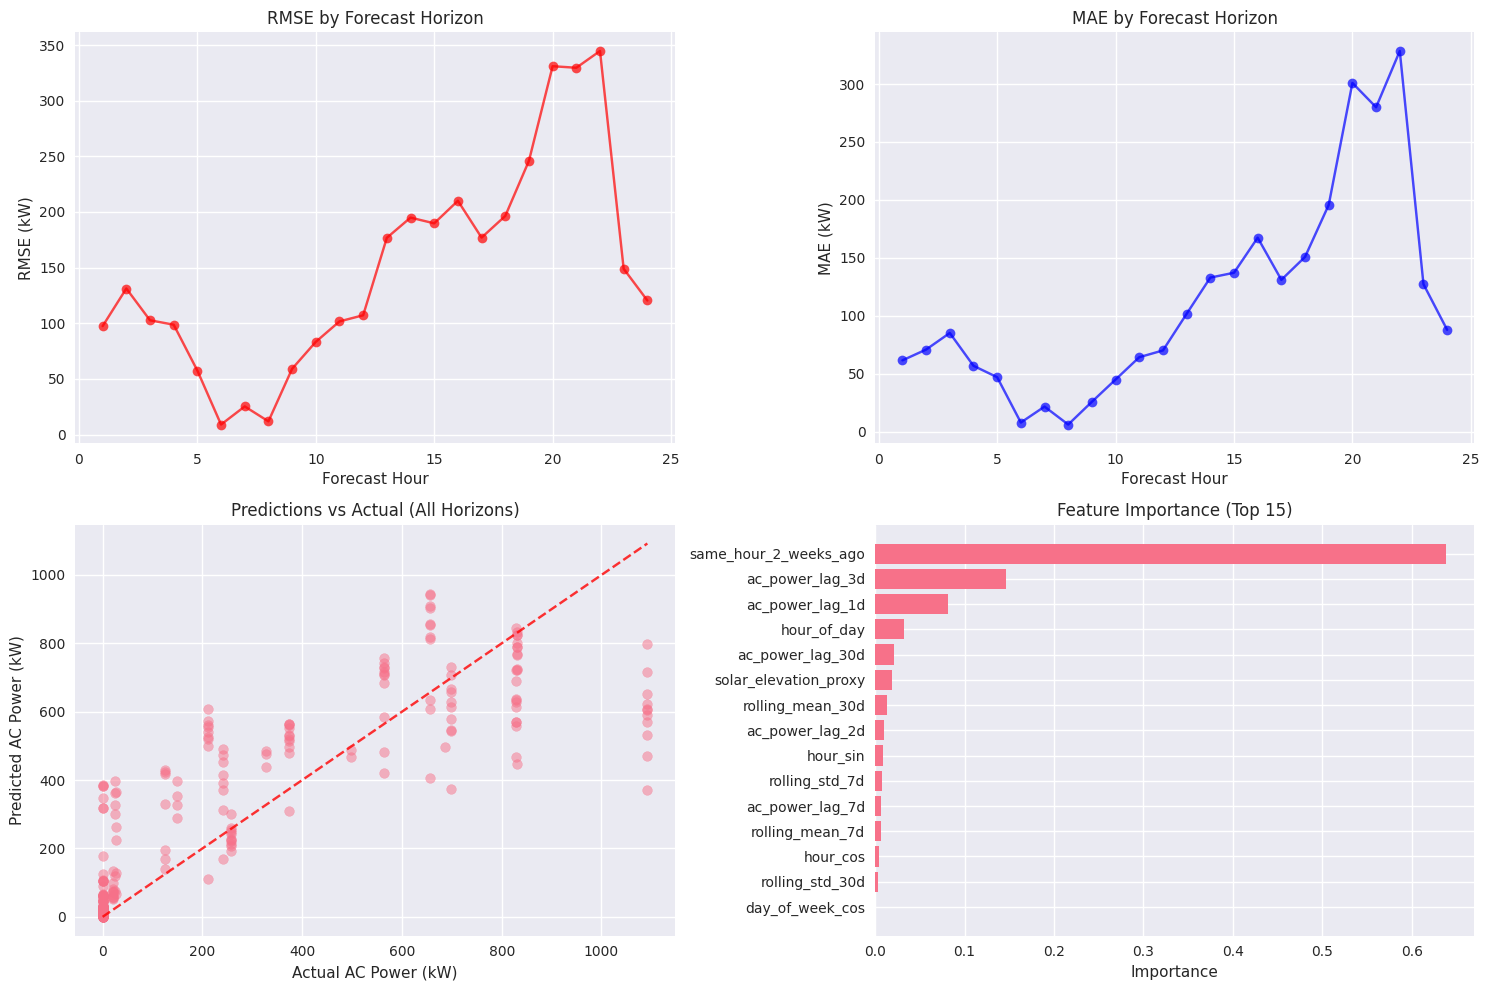

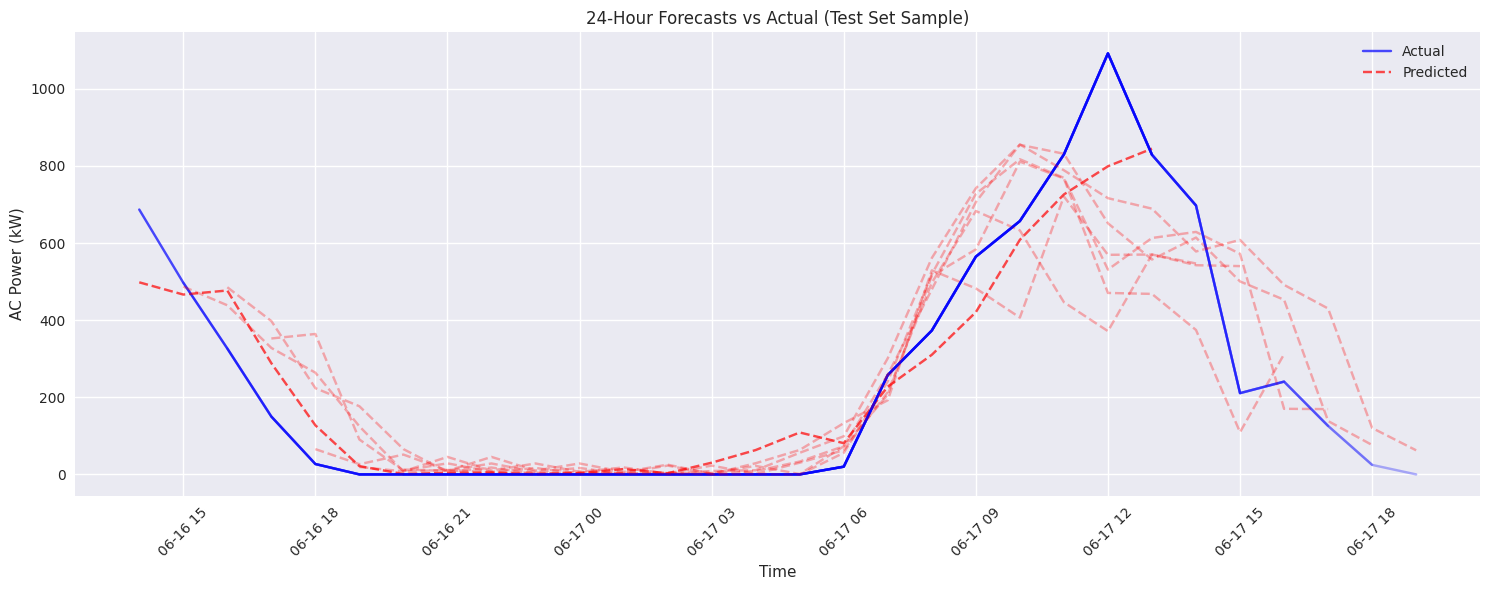

FORECAST PERFORMANCE SUMMARY
Overall RMSE: 175.24 kW
Overall MAE:  112.72 kW
Overall R²:   0.725

Per-horizon performance:
   1h ahead: RMSE 97.50, MAE 61.65
   6h ahead: RMSE 9.08, MAE 8.01
  12h ahead: RMSE 107.24, MAE 70.20
  24h ahead: RMSE 120.51, MAE 87.98


In [12]:
def analyze_forecast_performance(
    model: MultiOutputRegressor,
    X_test: pd.DataFrame,
    y_test: pd.DataFrame,
    feature_names: List[str]
) -> None:
    """
    Comprehensive analysis of forecasting model performance.
    
    Args:
        model: Trained model
        X_test: Test features
        y_test: Test targets
        feature_names: List of feature names
    """
    # Make predictions
    X_test_features = X_test.drop('DATE_TIME', axis=1)
    y_pred = model.predict(X_test_features)
    
    # === 1. Per-horizon performance ===
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # RMSE by forecast horizon
    horizon_rmse = []
    horizon_mae = []
    for h in range(y_test.shape[1]):
        h_rmse = np.sqrt(mean_squared_error(y_test.iloc[:, h], y_pred[:, h]))
        h_mae = mean_absolute_error(y_test.iloc[:, h], y_pred[:, h])
        horizon_rmse.append(h_rmse)
        horizon_mae.append(h_mae)
    
    hours = list(range(1, 25))
    axes[0, 0].plot(hours, horizon_rmse, 'o-', color='red', alpha=0.7)
    axes[0, 0].set_title('RMSE by Forecast Horizon')
    axes[0, 0].set_xlabel('Forecast Hour')
    axes[0, 0].set_ylabel('RMSE (kW)')
    axes[0, 0].grid(True)
    
    axes[0, 1].plot(hours, horizon_mae, 'o-', color='blue', alpha=0.7)
    axes[0, 1].set_title('MAE by Forecast Horizon')
    axes[0, 1].set_xlabel('Forecast Hour')
    axes[0, 1].set_ylabel('MAE (kW)')
    axes[0, 1].grid(True)
    
    # === 2. Prediction vs Actual scatter ===
    axes[1, 0].scatter(y_test.values.flatten(), y_pred.flatten(), alpha=0.5)
    axes[1, 0].plot([0, y_test.values.max()], [0, y_test.values.max()], 'r--', alpha=0.8)
    axes[1, 0].set_xlabel('Actual AC Power (kW)')
    axes[1, 0].set_ylabel('Predicted AC Power (kW)')  
    axes[1, 0].set_title('Predictions vs Actual (All Horizons)')
    axes[1, 0].grid(True)
    
    # === 3. Feature importance (from first estimator) ===
    if hasattr(model.estimators_[0], 'feature_importances_'):
        importances = model.estimators_[0].feature_importances_
        sorted_idx = np.argsort(importances)[-15:]  # Top 15 features
        
        axes[1, 1].barh(range(len(sorted_idx)), importances[sorted_idx])
        axes[1, 1].set_yticks(range(len(sorted_idx)))
        axes[1, 1].set_yticklabels([feature_names[i] for i in sorted_idx])
        axes[1, 1].set_title('Feature Importance (Top 15)')
        axes[1, 1].set_xlabel('Importance')
    
    plt.tight_layout()
    plt.show()
    
    # === 4. Time series plot of predictions ===
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Plot last week of test data
    plot_samples = min(7 * 24 // y_test.shape[1], len(X_test))  # Roughly a week
    plot_samples = min(plot_samples, len(X_test))
    
    for sample_idx in range(plot_samples):
        # Get the prediction date
        pred_date = X_test.iloc[sample_idx]['DATE_TIME']
        
        # Create hourly timestamps for the 24h forecast
        forecast_times = pd.date_range(
            start=pred_date + timedelta(hours=1),
            periods=24,
            freq='H'
        )
        
        # Plot actual and predicted
        if sample_idx == 0:  # Labels only for first series
            ax.plot(forecast_times, y_test.iloc[sample_idx], 'b-', alpha=0.7, label='Actual')
            ax.plot(forecast_times, y_pred[sample_idx], 'r--', alpha=0.7, label='Predicted')
        else:
            ax.plot(forecast_times, y_test.iloc[sample_idx], 'b-', alpha=0.3)
            ax.plot(forecast_times, y_pred[sample_idx], 'r--', alpha=0.3)
    
    ax.set_title('24-Hour Forecasts vs Actual (Test Set Sample)')
    ax.set_xlabel('Time')
    ax.set_ylabel('AC Power (kW)')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # === 5. Performance summary ===
    print("FORECAST PERFORMANCE SUMMARY")
    print("=" * 50)
    print(f"Overall RMSE: {np.sqrt(mean_squared_error(y_test.values, y_pred)):.2f} kW")
    print(f"Overall MAE:  {mean_absolute_error(y_test.values, y_pred):.2f} kW")
    print(f"Overall R²:   {r2_score(y_test.values.flatten(), y_pred.flatten()):.3f}")
    print("\nPer-horizon performance:")
    for h in [0, 5, 11, 23]:  # 1h, 6h, 12h, 24h
        h_rmse = np.sqrt(mean_squared_error(y_test.iloc[:, h], y_pred[:, h]))
        h_mae = mean_absolute_error(y_test.iloc[:, h], y_pred[:, h])
        print(f"  {h+1:2d}h ahead: RMSE {h_rmse:.2f}, MAE {h_mae:.2f}")

# Run performance analysis
print("Analyzing final model performance...")
analyze_forecast_performance(final_model, X_test_final, y_test_final, preprocessor.get_feature_names())

## 8. Midnight Prediction Test (Operational Mode)

INFO:src.data.preprocessor:Loading solar generation data...
INFO:src.data.preprocessor:Resampling to hourly frequency...
INFO:src.data.preprocessor:Removed 20 NaN rows after resampling
INFO:src.data.preprocessor:Data loaded successfully: 796 records from 2020-05-15 00:00:00 to 2020-06-17 23:00:00
INFO:src.data.preprocessor:Preparing midnight prediction for 2020-06-15
INFO:src.data.preprocessor:Creating historical lag features...
INFO:src.data.preprocessor:Created 5 lag features and 2 rolling features
INFO:src.data.preprocessor:Creating temporal features for future dates...
INFO:src.data.preprocessor:Created 16 temporal features
INFO:src.data.preprocessor:Midnight prediction features prepared: (2, 32)


OPERATIONAL MIDNIGHT PREDICTION TEST
   Prediction date: 2020-06-15
   Scenario: Predict 2020-06-15 01:00-24:00 at 2020-06-15 00:00


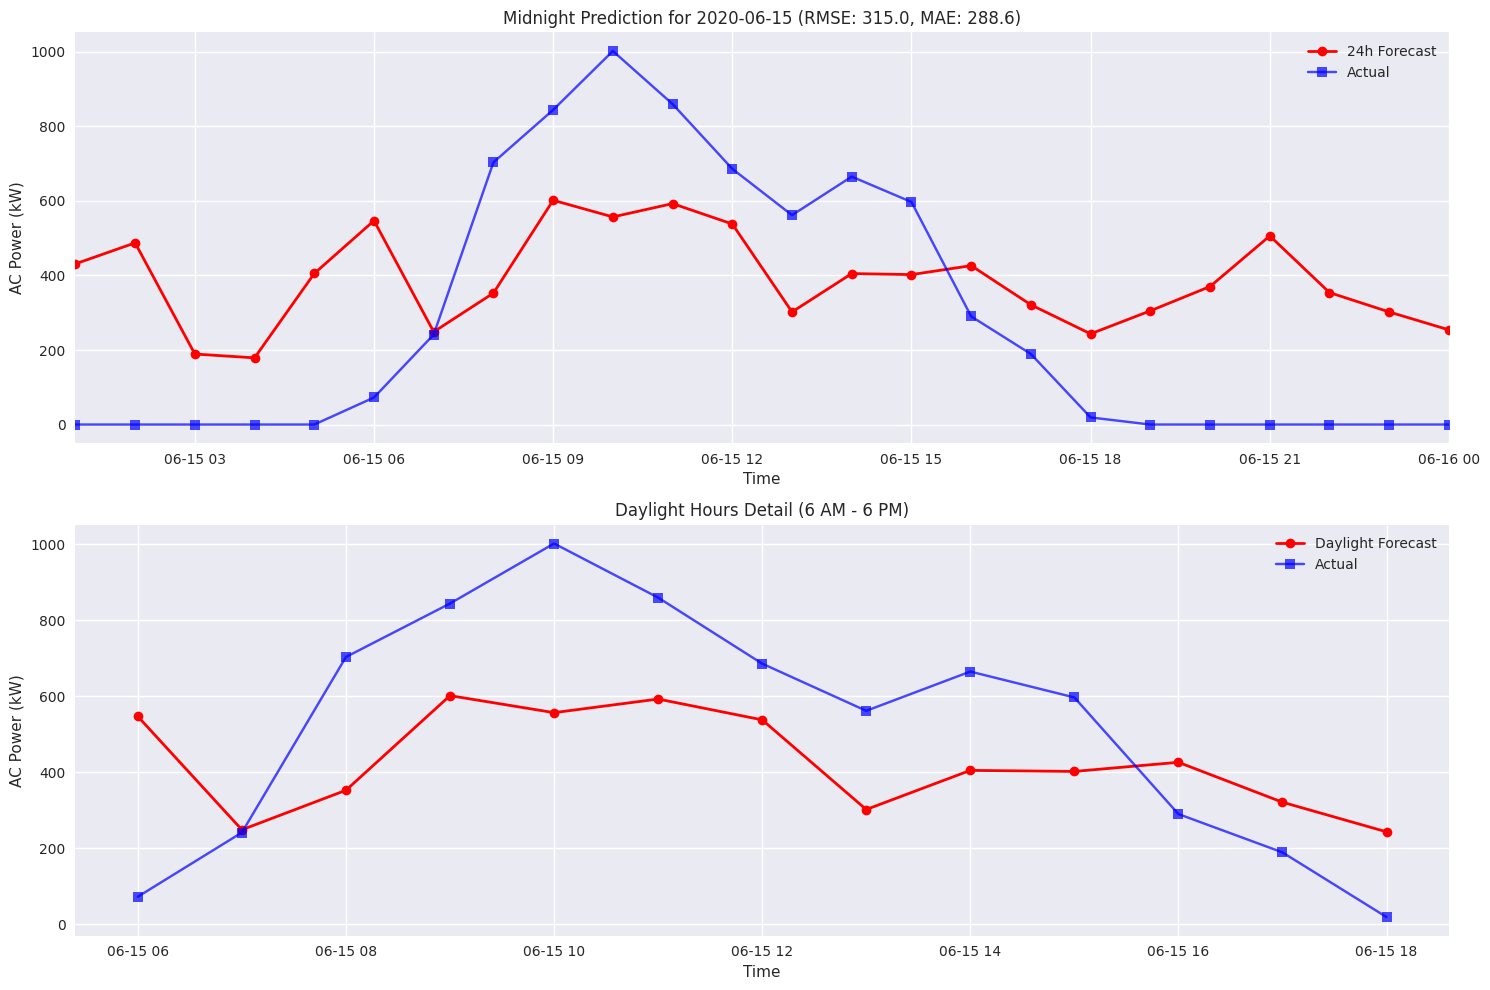


FORECAST SUMMARY:
   Peak predicted power: 601.8 kW at hour 9
   Total predicted energy: 9322.8 kWh
   Daylight hours (6-18): 5297.0 kWh
   Night hours: 4025.8 kWh

VALIDATION AGAINST ACTUALS:
   RMSE: 314.98 kW
   MAE:  288.60 kW
   Peak actual: 1002.2 kW
   Total actual energy: 6732.8 kWh

✅ OPERATIONAL TEST: PASSED


In [13]:
def test_operational_midnight_prediction(
    model: MultiOutputRegressor,
    preprocessor: SolarForecastingPreprocessor,
    test_date: str = "2020-06-15"
) -> None:
    """
    Test operational midnight prediction scenario.
    
    Args:
        model: Trained forecasting model
        preprocessor: Fitted preprocessor
        test_date: Date to test prediction for (YYYY-MM-DD)
    """
    print(f"OPERATIONAL MIDNIGHT PREDICTION TEST")
    print(f"   Prediction date: {test_date}")
    print(f"   Scenario: Predict {test_date} 01:00-24:00 at {test_date} 00:00")
    
    # Load raw data for midnight prediction
    df, _ = preprocessor.load_and_prepare_data(
        "../data/raw/Plant_1_Generation_Data.csv",
        "../data/raw/Plant_1_Weather_Sensor_Data.csv"
    )
    
    try:
        # Prepare midnight features (operational scenario)
        midnight_features = preprocessor.prepare_midnight_prediction(df, test_date)
        
        # Remove DATE_TIME for prediction
        features_for_model = midnight_features.drop('DATE_TIME', axis=1)
        
        # Make 24-hour prediction
        forecast_24h = model.predict(features_for_model)
        
        # Get actual values for comparison (if available)
        test_datetime = pd.to_datetime(test_date)
        actual_start = test_datetime + timedelta(hours=1)
        actual_end = test_datetime + timedelta(hours=24)
        
        actual_mask = (df['DATE_TIME'] >= actual_start) & (df['DATE_TIME'] <= actual_end)
        actual_values = df[actual_mask]['AC_POWER'].values
        
        # Create forecast timeline
        forecast_times = pd.date_range(
            start=actual_start,
            periods=24,
            freq='H'
        )
        
        # Plot comparison
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Full day forecast
        ax1.plot(forecast_times, forecast_24h[0], 'r-', marker='o', label='24h Forecast', linewidth=2)
        if len(actual_values) == 24:
            ax1.plot(forecast_times, actual_values, 'b-', marker='s', label='Actual', alpha=0.7)
            
            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(actual_values, forecast_24h[0]))
            mae = mean_absolute_error(actual_values, forecast_24h[0])
            ax1.set_title(f'Midnight Prediction for {test_date} (RMSE: {rmse:.1f}, MAE: {mae:.1f})')
        else:
            ax1.set_title(f'Midnight Prediction for {test_date}')
        
        ax1.set_xlabel('Time')
        ax1.set_ylabel('AC Power (kW)')
        ax1.legend()
        ax1.grid(True)
        ax1.set_xlim(forecast_times[0], forecast_times[-1])
        
        # Daylight hours zoom (6 AM - 6 PM)
        daylight_mask = (forecast_times.hour >= 6) & (forecast_times.hour <= 18)
        daylight_times = forecast_times[daylight_mask]
        
        ax2.plot(daylight_times, forecast_24h[0][daylight_mask], 'r-', marker='o', 
                label='Daylight Forecast', linewidth=2)
        if len(actual_values) == 24:
            ax2.plot(daylight_times, actual_values[daylight_mask], 'b-', marker='s', 
                    label='Actual', alpha=0.7)
        
        ax2.set_title('Daylight Hours Detail (6 AM - 6 PM)')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('AC Power (kW)')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Print forecast summary
        print(f"\nFORECAST SUMMARY:")
        print(f"   Peak predicted power: {forecast_24h[0].max():.1f} kW at hour {np.argmax(forecast_24h[0])+1}")
        print(f"   Total predicted energy: {forecast_24h[0].sum():.1f} kWh")
        print(f"   Daylight hours (6-18): {forecast_24h[0][6:19].sum():.1f} kWh")
        print(f"   Night hours: {(forecast_24h[0][:6].sum() + forecast_24h[0][19:].sum()):.1f} kWh")
        
        if len(actual_values) == 24:
            print(f"\nVALIDATION AGAINST ACTUALS:")
            print(f"   RMSE: {rmse:.2f} kW")
            print(f"   MAE:  {mae:.2f} kW")
            print(f"   Peak actual: {actual_values.max():.1f} kW")
            print(f"   Total actual energy: {actual_values.sum():.1f} kWh")
        
        print(f"\n✅ OPERATIONAL TEST: PASSED")
        
    except Exception as e:
        print(f"OPERATIONAL TEST FAILED: {e}")

# Run operational test
test_operational_midnight_prediction(final_model, preprocessor, "2020-06-15")